# Finding the optimal portfolio allocation via Policy Gradient Methods

In [1]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from statsmodels.tsa.api import VAR
import random
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.optimize as sci
import seaborn as sns

#### divide data in training and test
#### on traing data: estimate VAR, generate synthetic data and return data frame

In [2]:
# function estimates VAR and returns model and dataset
def estimate_VAR(data):
    # take difference of timeseries to avoid stationarity
    data_stationary = data.diff().dropna()

    # fit VAR
    var_model = VAR(data_stationary)
    var_model_fitted = var_model.fit()
    return var_model_fitted

In [3]:
# function generates a data set of size num_obs - 1
# forecast horizon is 1 months but can be changed
# num_obs cannot be larger than df.shape[0]
def generate_data(df, df_stationary, model_fitted, numb_obs, forecast_window = 1):

    lag_order = model_fitted.k_ar

    # inputs to generate a random vector
    mean_vector = np.zeros(df_stationary.shape[1])
    covariance_matrix = df_stationary.cov()

    # instantiate dataframes to store the results
    df_results = pd.DataFrame(columns=df.columns, index=range(numb_obs))
    df_forecast = pd.DataFrame(columns=df.columns, index=range(numb_obs))

    # all subsequent data points in forecast
    for i in range(lag_order, numb_obs):
        forecast_input = df_stationary.values[i-lag_order: i] 
        fc = model_fitted.forecast(y=forecast_input, steps=forecast_window)
        df_forecast.iloc[i-lag_order,:] = fc + np.random.multivariate_normal(mean_vector, covariance_matrix)
        df_results.iloc[i,:] = df.iloc[i-lag_order,:] + fc[0] + np.random.multivariate_normal(mean_vector, covariance_matrix)

    return df_results

In [4]:
def plot_probabilities(probabilities):
    # Anzahl der Zeitpunkte
    time_points = np.arange(len(probabilities))

    # Separate Listen für jede Wahrscheinlichkeit extrahieren
    prob_a = [p[0] for p in probabilities]
    prob_b = [p[1] for p in probabilities]
    prob_c = [p[2] for p in probabilities]
    prob_d = [p[3] for p in probabilities]

    # Liniendiagramm erstellen
    plt.plot(time_points, prob_a, label='S&P')
    plt.plot(time_points, prob_b, label='Gold')
    plt.plot(time_points, prob_c, label='3M')
    plt.plot(time_points, prob_d, label='10y')


    # Achsenbeschriftungen und Titel hinzufügen
    plt.xlabel('Zeitpunkte')
    plt.ylabel('Wahrscheinlichkeiten')
    plt.title('Verlauf der Wahrscheinlichkeiten über die Zeit')

    # Legende anzeigen
    plt.legend()
    plt.show()


In [5]:
def crra(vector, gamma = 2):
    result_vector = []
    for i in range(len(vector)):
        result_vector.append((1/(1-gamma))*math.pow(vector[i],1-gamma))
    if isinstance(vector, np.ndarray):
        result = np.array(result_vector)
    elif isinstance(vector, torch.Tensor):
        result = torch.Tensor(result_vector)
    else:
        result = result_vector
    return result


### functions to measure performance

In [6]:
def max_draw_down(input_list):
    max_draw = np.inf
    for i in range(1, len(input_list)):
        draw_down = input_list[i] - input_list[i-1]
        if draw_down < max_draw:
            max_draw = draw_down
    return max_draw

def average_return(input_list):
    series = pd.Series(input_list).diff()
    return np.mean(series)*12

def std_of_return(input_list):
    series = pd.Series(input_list).diff()
    return series.dropna().std() * math.sqrt(12)

def performance(input_list):
    print(f'average p.a. return: {round(average_return(input_list=input_list)*100,2)}%')
    print(f'max. draw down : {round(max_draw_down(input_list=input_list)*100,2)}%')
    print(f'Sharpe-ratio: {round(average_return(input_list=input_list)/std_of_return(input_list=input_list),2)}')
    print("")


### functions to calculate the portfolio with the highest Sharpe ratio

In [7]:
# function to calculate portfolio return given a vector of weights
def portfolio_return_mu(weights, mu):
    return weights.T @ mu

# function to calculate portfolio risk (std) given a vector of weights
def portfolio_sigma(weights, sigma):
    return np.sqrt(weights.T @ sigma @ weights)

# Function for computing portfolio return for monthly data
#def portfolio_returns(weights, data):
#    return (np.sum(data * weights)) 

# Function for computing standard deviation of portfolio returns for monthly data
#def portfolio_sd(weights, data):
#    return np.sqrt(np.transpose(weights) @ (np.cov(data)) @ weights)

# Return an array of equal weights that sum to one of dimension length
def get_equal_weights(length):
    return np.array([1 / length] * length)

### function to determine the highest Sharpe-ratio

In [46]:
# find the highest Sharpe-ratio

def calc_efficient_frontier(n_assets, mu, sigma,  n_portfolios = 500000):
    # container to store results
    portfolio_returns = []
    portfolio_risks = []
    portfolio_weights = []

    max_sharpe_ratio = -np.inf

    # simulate random portfolios
    for _ in range(n_portfolios):
        # random weights
        weights = np.random.random(n_assets)
        weights /= np.sum(weights)  # normalize to sume to one
        
        # calc expected return of portfolio
        portfolio_return =  portfolio_return_mu(mu = mu, weights = weights) *12 # to get p.a. values
        
        # calc portfolio risk (std)
        portfolio_std_dev =  portfolio_sigma(weights=weights, sigma=sigma) * np.sqrt(12)
        
        # store results
        portfolio_returns.append(portfolio_return)
        portfolio_risks.append(portfolio_std_dev)
        portfolio_weights.append(weights)

        if portfolio_return / portfolio_std_dev > max_sharpe_ratio:
            sharpe_return = portfolio_return
            sharpe_std = portfolio_std_dev
            max_sharpe_ratio = portfolio_return / portfolio_std_dev 
            max_sharpe_ratio_weights = weights

    # approximate efficient frontier
    portfolio_returns = np.array(portfolio_returns)
    portfolio_risks = np.array(portfolio_risks)
    portfolio_weights = np.array(portfolio_weights)

    efficient_frontier = list(zip(portfolio_risks, portfolio_returns, portfolio_weights))
    return efficient_frontier

def Sharpe_ratio(r_f, efficient_frontier, gamma=2):
    # find portfolio on efficient frontier with highest Sharpe-ratio
    

    # determine tangent point
    max_sharpe_return = -np.inf
    max_sharpe_risk = -np.inf
    sharpe = -np. inf
    for tupel in efficient_frontier:
        if (tupel[1] - r_f) / tupel[0] > sharpe:
            max_sharpe_return = tupel[1]
            max_sharpe_risk = tupel[0]
            sharpe = (tupel[1] - r_f) / tupel[0]
            ratios = tupel[2]
    
     # determine the where on the Capital asset line the investor optimal portfolio is located
    p_star = 0.75# max(min((max_sharpe_return -r_f)/(gamma * math.pow(max_sharpe_risk,2) ),1),0) # p_star is between 0 and 1
    tupel = (p_star*ratios[0], p_star * ratios[1], 1-p_star)
    return tupel


### Thompson Sampling

In [26]:
class AssetThompsonSampler():
    def __init__(self, prior_mu, prior_sigma, kappa_null): # mu and sigma are parameters of true distribution
        # prior_mu und prior_sigma are estimates
        self.prior_mu = prior_mu
        self.prior_sigma = prior_sigma
        
        self.post_mu = self.prior_mu
        self.post_sigma = self.prior_sigma
        
        self.n = 0
        self.kappa_null = kappa_null # prior.mu / prio.sigma was estimated with kappa_null observations
        self.phi = prior_sigma
      
    def drawing_from_posterior_distribution(self):
        # sample_mu = np.random.multivariate_normal(self.post_mu, self.post_sigma)
        # return mu and sigma of posterior since active choice of agent has no influence to prices
        return self.post_mu, self.post_sigma
    
    def update_current_distribution(self, ret, freq):
        kappa_n = self.kappa_null + freq # there is only one observation new per update
        x_bar = np.average(ret, axis=0) # average of new sample

        deviations = ret - x_bar
        self.C = np.cov(deviations, rowvar=False)

        #C  = 0
        #for i in range(freq):
        #    C += (ret[i] - x_bar)*(ret[i] - x_bar).T
        #self.C = C#np.cov(ret.T) #covariance of new sample
        
        self.post_mu = (self.kappa_null * self.post_mu + freq* x_bar) / kappa_n
        self.post_sigma = self.phi + self.C + (self.kappa_null*freq)/(kappa_n) * (x_bar -self.prior_mu)*(x_bar -self.prior_mu).T
        #self.post_sigma = (self.kappa_null * self.post_sigma + freq *cov_new)/kappa_n

        # check covariance matrix to prevent it from exploding
        scale_factor = np.linalg.norm(self.post_sigma) / np.linalg.norm(self.prior_sigma)
    
        if scale_factor > 1.5:  
             self.post_sigma =  self.post_sigma / scale_factor  # scale covariance matrix back

        self.n += freq
        self.kappa_null += freq

### Only MPT and TS

In [62]:
# get data
df = pd.read_csv('../Data/20241010_data.csv', delimiter=";").dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
# set date column as index
df.set_index('Date', inplace=True)
df.drop('UofM consumer sentiment', axis=1, inplace=True) # drop consumer confidence for now

df.drop('10y treasury Index', axis=1, inplace=True) # drop consumer confidence for now
ten_y_index = [100]
delta = -9.0/100.0
for i in range(len(df['10y'])-1):
    change_in_bp = (df['10y'][i+1] - df['10y'][i])/ df['10y'][i]
    ten_y_index.append(ten_y_index[i] + df['10y'][i]/(12) + change_in_bp * delta)

df['10y treasury Index'] = np.array(ten_y_index)


# split data in training and test set
split = 0.8
split_obs = int(df.shape[0] * split)
df_training = df[0:split_obs]
df_test = df[split_obs::]


# all assets
data_all_assets_training = df_training[['SP500','Gold','3M-Index']]
data_all_assets_training = data_all_assets_training.pct_change().dropna()

data_all_assets_test = df_test[['SP500','Gold','3M-Index']]
data_all_assets_test = data_all_assets_test.pct_change().dropna()


# select only the assets for the risky portfolio
data_risky_assets_training = df_training[['SP500','Gold']]
data_risky_assets_training = data_risky_assets_training.pct_change().dropna()

data_risky_assets_test = df_test[['SP500','Gold']]
data_risky_assets_test = data_risky_assets_test.pct_change().dropna()

# first 10y of data used to as history for learning and first distribution of prices
start = 120 # in months

# flag if system should retrain
retrain = False
retrain_freq = 120 # in months
freq = 12 # monthly updates for TS

# parameter for risk preference
gamma = 0.25

# calculate the mean and the standard deviation of the trainings data
mu = data_risky_assets_training.iloc[0:start,:].mean(axis=0).to_numpy()
sigma = data_risky_assets_training.iloc[0:start,:].cov().to_numpy() 

# prior distribtion is given by current data => initial portfolio choice between Thompson Sampling and MPT identical
Thompson_Sampler = AssetThompsonSampler(prior_mu = mu, prior_sigma = sigma, kappa_null = start)

profit_mpt_list = []
profit_ts_list = []
#profit_rl_list = []

portfolio_mpt = []
portfolio_ts = []
#portfolio_rl = []

profit_mpt = 0
profit_ts = 0
#profit_rl = 0

efficient_frontier_mpt = calc_efficient_frontier(n_assets=data_risky_assets_training.shape[1], mu=mu, sigma=sigma)

for i in range(start, 530, freq):

    # risk-free rate
    r_f = df['3M'][i] / 100
     
    # get a sample from each posterior
    post_mu, post_sigma = Thompson_Sampler.drawing_from_posterior_distribution()
 
    # mpt
    portfolio_choice_mpt = Sharpe_ratio(r_f = r_f, efficient_frontier=efficient_frontier_mpt, gamma=gamma)

    # TS
    efficient_frontier_ts = calc_efficient_frontier(n_assets=data_risky_assets_training.shape[1], mu = post_mu, sigma = post_sigma)
    portfolio_choice_ts = Sharpe_ratio(r_f = r_f, efficient_frontier=efficient_frontier_ts, gamma=gamma)

    # update TS after a complete year of fresh data was collected

    if ((i - start)%freq==0 ):
        # get a new sample from the real distribution which is unknown
        return_risky_assets =  data_risky_assets_training.iloc[i-12:i,:].to_numpy().astype(float) 
        
        # update that distributions posterior
        Thompson_Sampler.update_current_distribution(return_risky_assets, freq = freq)

    # performance of assets
    perf_all_assets = data_all_assets_training.iloc[i,:] * 12 # to get p.a. returns

    # calulate profit for MPT and Thompson Sampling
    profit_mpt += np.dot(perf_all_assets,portfolio_choice_mpt)
    profit_ts += np.dot(perf_all_assets,portfolio_choice_ts)

    # store profit
    profit_mpt_list.append(profit_mpt)
    profit_ts_list.append(profit_ts)

    # get data for nn model
    #obs = pd.DataFrame(df_training_scaled).iloc[i,:].to_numpy().astype(float)
    #prob = model(torch.from_numpy(obs).float()) # get probability distribution

    # store the weights of the portfolios
    portfolio_mpt.append(portfolio_choice_mpt)
    portfolio_ts.append(portfolio_choice_ts)
    #portfolio_rl.append(prob)

    # calculate profit for RL
    #profit_rl += perf_all_assets@prob.detach().numpy()
    #profit_rl_list.append(profit_rl) 

    if retrain and (i % retrain_freq == 0):
        # calculate the mean and the standard deviation of the data
        mu = data_risky_assets_training.iloc[i-retrain_freq:i,:].mean(axis=0).to_numpy()
        sigma = data_risky_assets_training.iloc[i-retrain_freq:i,:].cov().to_numpy() 


        # prior distribtion is given by current data => initial portfolio choice between Thompson Sampling and MPT identical
        Thompson_Sampler = AssetThompsonSampler(prior_mu = mu, prior_sigma = sigma, kappa_null = retrain_freq)

        #df_RL = data_rl_training[0:i]
        # Reinforecement Learning
        #model = Reinforcement_Learning(df=df_RL, numb_obs=i)



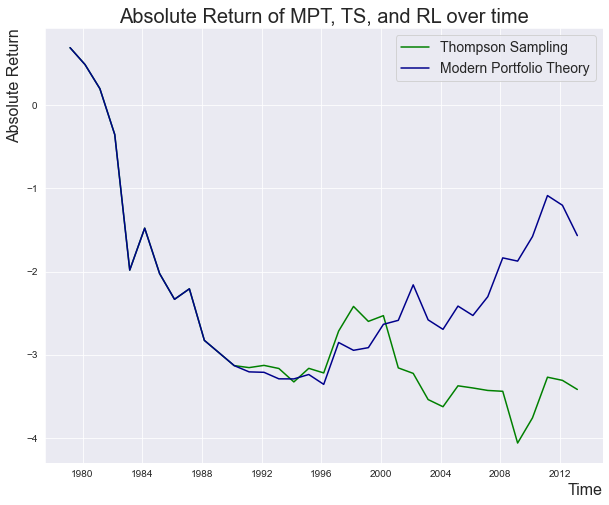

In [63]:
# graphic display of performance over time
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 8))
x = data_all_assets_training.index[120:530:freq]
plt.plot(x, profit_ts_list, label = 'Thompson Sampling', color = 'green')
plt.plot(x, profit_mpt_list, label = 'Modern Portfolio Theory', color = 'darkblue')
#plt.plot(x, profit_rl_list, label = 'Reinforcement Learning', color = 'red')
plt.xlabel('Time', loc='right', fontsize=16)
plt.ylabel('Absolute Return', loc='top', fontsize=16)
plt.title('Absolute Return of MPT, TS, and RL over time', fontsize=20)
plt.legend(fontsize=14)
plt.show()
plt.show()

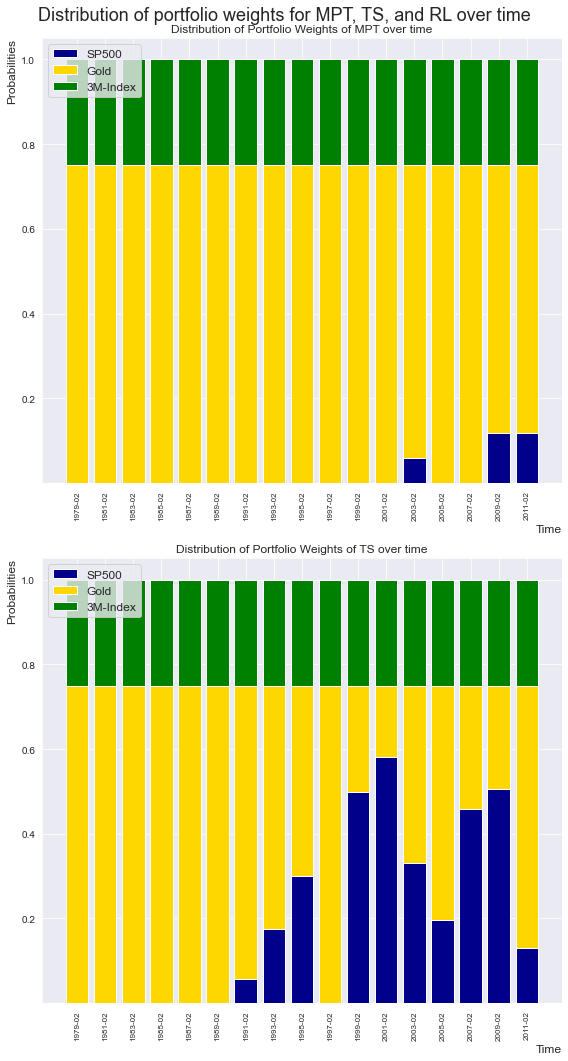

In [64]:
# labels
categories = ['SP500','Gold','3M-Index']
names = ['MPT','TS']

portfolios = [portfolio_mpt, portfolio_ts]

 # set-up graphic
sns.set_style('darkgrid')
fig, ax = plt.subplots(2, 1, figsize=(8, 15))

for j, port in enumerate(portfolios):
    # take every 10th portfolio weight and write it into a list 

    container = []
    x_axis = []
    for i in range(math.floor(len(port)/2)):
        container.append(port[i*2])
        x_axis.append(data_all_assets_training.index[start+i*freq*2].strftime('%Y-%m'))

    # x- axis
    n_timepoints = len(container)
    x = np.arange(n_timepoints)

    # define colours
    colors = ['darkblue', 'gold', 'green', 'red']

    # bars starting at zero
    bottom = np.zeros(n_timepoints)

    # stacked bar chart
    for i, category in enumerate(categories):
        heights = [probabilities[i] for probabilities in container]
        ax[j].bar(x, heights, bottom=bottom, label=category, color=colors[i])
        # Update der 'bottom'-Positionen für das nächste Segment
        bottom += heights



        # labelling of axis
        ax[j].set_xlabel('Time', loc='right', fontsize=12)
        ax[j].set_xticks(x)
        ax[j].set_xticklabels(x_axis, fontsize=8, rotation=90)
        ax[j].set_ylabel('Probabilities',loc='top', fontsize=12)
        ax[j].set_title(f'Distribution of Portfolio Weights of {names[j]} over time', fontsize=12)

        # add legend 
        ax[j].legend( loc=2, fontsize=12)

plt.suptitle('Distribution of portfolio weights for MPT, TS, and RL over time', fontsize = 18)
plt.tight_layout()
plt.show()

In [51]:
performance(profit_ts_list)
performance(profit_mpt_list)

average p.a. return: 5.29%
max. draw down : -13.58%
Sharpe-ratio: 0.41

average p.a. return: 3.78%
max. draw down : -13.58%
Sharpe-ratio: 0.28

